# Direct Collapse Black Holes from Axion Decay

This file models DCBHs from axions decay

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
 %reload_ext autoreload

In [29]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from physics import definitions as phys

# import integrators
import scipy.integrate as integrate
from scipy.integrate import quad_vec
# import derivatives
from scipy.misc import derivative
# import interpolator
from scipy.interpolate import interp1d
# import system solver 
from scipy.optimize import fsolve

# import pandas for cosmic variance
import pandas as pd

In [2]:
# Set parameters for plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "arial",
    "font.serif": ["Computer Modern Roman"],
    'font.size': 14
})

## IGM Mean Intensity

In [3]:
# Axion Decay rate (s^-1)
def gamma_decay(ma,ga):
    return (ma*1e-9)**3 * ga**2 *phys.GeV_To_InvSec/(64*phys.pi)

# A list containing Hydrogen n>=3 levels
H_levels = phys.lyman_np_level(np.arange(3,23))


In [4]:
def closest_below(arr, val):
    arr = np.asarray(arr)
    val = np.asarray(val)
    
    # Create an output array of the same shape as val to store results
    result = np.full_like(val, np.nan, dtype=float)
    
    for i, v in np.ndenumerate(val):
        # Filter arr to include only elements smaller than the given number
        smaller_elements = arr[arr < v]
        
        # If there are elements smaller than the number, get the maximum element
        if smaller_elements.size > 0:
            result[i] = smaller_elements.max()
    
    return result

In [5]:
closest_below(H_levels,12.5)

array(12.09394871)

In [6]:
print(12<H_levels[0])

True


Define a function for attenuated intensity

In [7]:
# Define a piecewise function for J_IGM using numpy select

def J_IGM_func(z, ma, ga, energy):

    ma = np.asarray(ma)
    energy = np.asarray(energy)
    
    closest_val = closest_below(H_levels, ma/2)

    # Define conditions for intensity
    conditions = [
        (ma/2 < H_levels[0]) & (energy<=ma/2),
        (H_levels[0] <= ma/2) & (energy >= closest_val) & (energy <= ma/2),
        (energy >= ma/2)
    ]

    # Define functions for these conditions
    functions=[
         (2 * phys.cs * phys.h_planck * phys.eV_to_ergs) / (4 * np.pi * phys.Hubble(z)) * \
            (phys.RhoCrit * phys.Omega_c * (1 + z) ** 3) / ma * gamma_decay(ma, ga) * \
            (2 * energy / ma) ** 1.5,
         (2 * phys.cs * phys.h_planck * phys.eV_to_ergs) / (4 * np.pi * phys.Hubble(z)) * \
            (phys.RhoCrit * phys.Omega_c * (1 + z) ** 3) / ma * gamma_decay(ma, ga) * \
            (2 * energy / ma) ** 1.5,
        0
    ]
    
    # Define intensity value for choice of inputs
    results = np.select(conditions, functions, default=0)

    return results

J_IGM = np.vectorize(J_IGM_func)
    

In [8]:
# Test with scalar inputs
scalar_result = J_IGM(20,25,1e-11,25/2)
print(f"Scalar result: {scalar_result}")

Scalar result: 1.486175599971085e-18


In [9]:
# Test with ma vector results
ma_ray=np.array([20,22,24,25.5])

J_IGM_func(20, ma_ray, 1e-11, 25/2)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.50096378e-18])

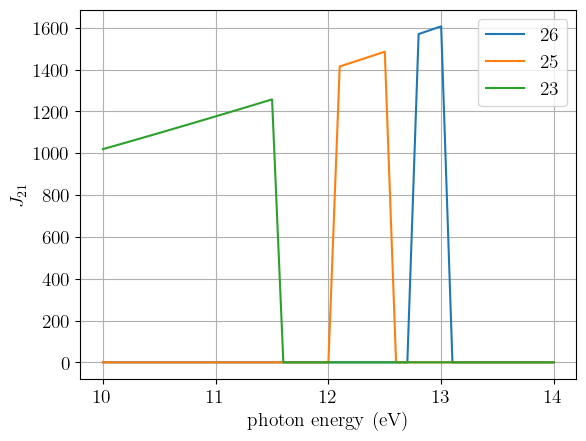

In [10]:
# Plot J IGM for different axion masses
en_space=np.arange(10,14.1,0.1)

plt.plot(en_space, 1e+21*J_IGM(20,26,1e-11, en_space), label=r'26')
plt.plot(en_space, 1e+21*J_IGM(20,25,1e-11, en_space), label=r'25')
plt.plot(en_space, 1e+21*J_IGM(20,23,1e-11, en_space), label=r'23')

plt.xlabel(r'photon energy (eV)')
plt.ylabel(r'$J_{21}$')
plt.legend()
plt.grid()
plt.show()

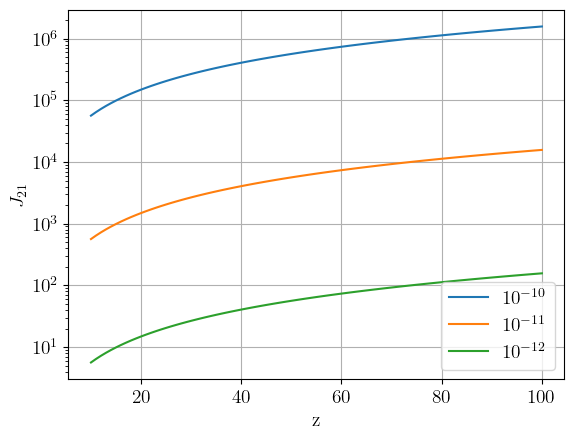

In [11]:
# Plot J_IGM vs z

z_space = np.arange(10,101)

plt.plot(z_space, 1e+21*J_IGM(z_space, 25,1e-10, 25/2), label=r'$10^{-10}$')
plt.plot(z_space, 1e+21*J_IGM(z_space, 25,1e-11, 25/2), label=r'$10^{-11}$')
plt.plot(z_space, 1e+21*J_IGM(z_space, 25,1e-12, 25/2), label=r'$10^{-12}$')

plt.yscale('log')
plt.xlabel(r'z')
plt.ylabel(r'$J_{21}$')
plt.legend()
plt.grid()
plt.show()

## Define Dissociation Rate Functions

In [12]:
# Define a simple function for Lyman Werner radiation 

def k_LW_func(z, ma, ga):
    ma = np.asanyarray(ma)
    const = 1.39e-12 * 1e+21/2
    closest_val = closest_below(H_levels, ma/2)

    # Define conditions for LW dissociation
    conditions=[
        (ma/2>=11.5) & (ma/2<H_levels[0]),
        (ma/2 >=H_levels[0]) & (ma/2 < phys.rydberg_energy),
        (ma/2 <11.5) & (ma/2>= phys.rydberg_energy)
    ]

    # Define dissociation rate values
    functions = [
        const*J_IGM(z,ma,ga,ma/2)*(ma/2 - 11.5)/2.1,
        const*J_IGM(z,ma,ga,ma/2)*(ma/2 - closest_val)/2.1,
        0
    ]

    # Define intensity value for choice of inputs
    results = np.select(conditions, functions, default=0)

    return results

k_LW = np.vectorize(k_LW_func)
                

In [13]:
k_LW(20,24,1e-11)

array(2.26646025e-10)

In [14]:
# Define a function for photodetachment

"""
Here use quad_vec function in the scipy.integrate library. 
This is suited for integration over functions with varying parameters, but makes the code inefficient.
This is probably the part with highest computation time.
"""

def k_pd_func(z, ma, ga):
    ma=np.asarray(ma)
    z=np.asarray(z)
    ga=np.asarray(ga)

    # Define a precursory constant
    const = 4*np.pi/(phys.h_planck * phys.eV_to_ergs)

    # Define a function for integration
    function = lambda en: const*J_IGM(z, ma, ga, en)*phys.sigma_Hm(en)/en

    result, error = quad_vec(function, 0.755, ma/2)

    return result

k_pd = np.vectorize(k_pd_func)

In [15]:
k_pd(np.array([20]),np.array([25]),1e-11)

array([4.0381108e-10])

In [16]:
J_IGM(20,24.25,1e-11,12.1)

array(1.39402008e-18)

In [17]:
k_pd(np.array([20]),np.array([2,4,6,8,10,25]),1e-11)

array([5.50019513e-11, 1.24836004e-09, 3.06036530e-09, 5.04542250e-09,
       7.07825847e-09, 4.03811080e-10])

Now plot the dissociation rate coefficients

In [18]:
ma_space = 2*np.linspace(11,13.55,5000)
k_LW_20 = k_LW(20, ma_space, 1e-11)
k_LW_40 = k_LW(40, ma_space, 1e-11)
k_LW_60 = k_LW(60, ma_space, 1e-11)

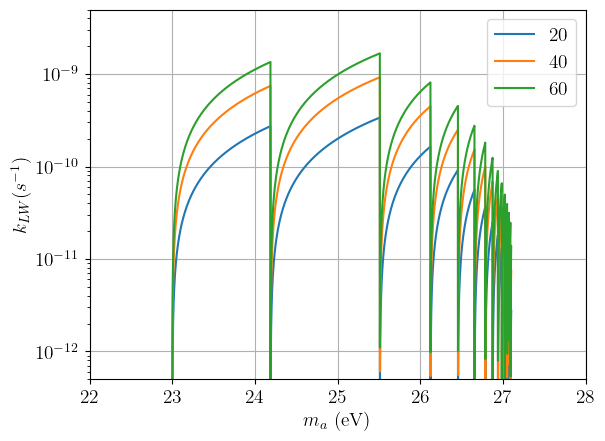

In [19]:
plt.figure()
plt.plot(ma_space, k_LW_20, label=r'20')
plt.plot(ma_space, k_LW_40, label=r'40')
plt.plot(ma_space, k_LW_60, label=r'60')

plt.yscale('log')
plt.xlim(22,28)
plt.ylim(5e-13, 5e-9)
plt.xlabel(r'$m_a$ (eV)')
plt.ylabel(r'$k_{LW} (s^{-1})$')
plt.legend()
plt.grid()
plt.show()

In [20]:
list1 = 2*np.linspace(0.755,10.95,100)
list2 = 2*np.linspace(11,13.59,250)

ma_list = np.concatenate((list1,list2))

In [21]:
%%time
k_pd_20 = k_pd (20, ma_list, 1e-11)

CPU times: user 23.2 s, sys: 94.6 ms, total: 23.3 s
Wall time: 23.7 s


In [22]:
k_pd_40 = k_pd (40, ma_list, 1e-11)
k_pd_60 = k_pd (60, ma_list, 1e-11)

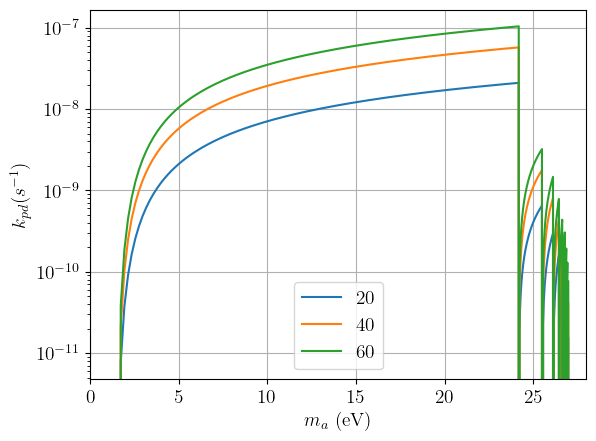

In [33]:
plt.figure()
plt.plot(ma_list,k_pd_20, label=r'20')
plt.plot(ma_list,k_pd_40, label=r'40')
plt.plot(ma_list,k_pd_60, label=r'60')

plt.yscale('log')
plt.xlabel(r'$m_a$ (eV)')
plt.ylabel(r'$k_{pd} (s^{-1})$')
plt.xlim(0,28)
plt.grid()
plt.legend()
plt.show()

## Toy Halo Model

In this section of the code, we describe a toy halo model. This includes behavior of dark matter, baryons, and temperature evolution in the standard picture.

We first begin with behavior of dark matter. In this case, we use Mass Accretion Histories, based on Extended Press-Schechter, described in [Correa 2015](https://academic.oup.com/mnras/article/450/2/1514/982398). The mass of a halo at any redshift may be written as:
$$
M_H (z) = M_0 (1+z)^{a f(M_0)} \exp{f(M_0)z} \ .
$$
Here, $M_0 \equiv M_\text{Halo}(z=0)$ is the only free parameter. The cosmology is encoded in $a$ and $f(M_0)$ via the growth factor $D(z)$, and the variance of the cosmic density field $\sigma(M)$ today (see eq.19-23 in [Correa 2015](https://academic.oup.com/mnras/article/450/2/1514/982398).


### Dark Matter

In [34]:
# Read the csv file in physics folder
var_path='./physics/Variance2.0.csv'
var_data=pd.read_csv(var_path, header=None, delimiter=',', lineterminator='\n')

In [35]:
pd.DataFrame(var_data)

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,1.000000e-09,1.020000e-09,1.050000e-09,1.070000e-09,1.100000e-09,1.120000e-09,1.150000e-09,1.170000e-09,1.200000e-09,1.230000e-09,...,7.940000e+15,8.130000e+15,8.320000e+15,8.510000e+15,8.710000e+15,8.910000e+15,9.120000e+15,9.330000e+15,9.550000e+15,9.770000e+15
1,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,...,2.900000e-01,2.880000e-01,2.860000e-01,2.840000e-01,2.820000e-01,2.800000e-01,2.780000e-01,2.750000e-01,2.730000e-01,2.710000e-01


In [36]:
# Create Data frames for each row - Row 1: mass, and Row 2: variance.

mass_list = var_data.iloc[0]
var_list = var_data.iloc[1]

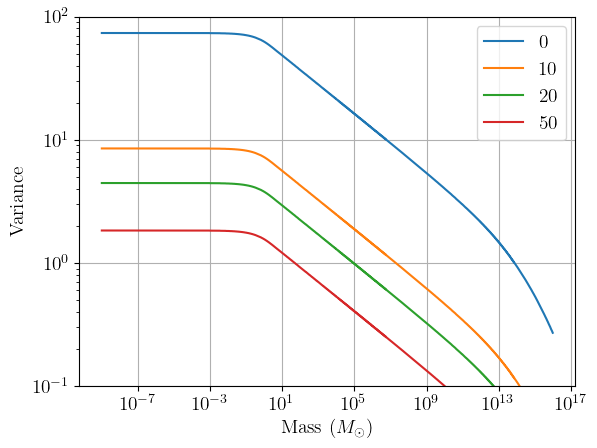

In [37]:
# Plot the variance

plt.figure()
plt.plot(mass_list, var_list, label=r'0')
plt.plot(mass_list, phys.growth_fac(10)*var_list, label=r'10')
plt.plot(mass_list, phys.growth_fac(20)*var_list, label=r'20')
plt.plot(mass_list, phys.growth_fac(50)*var_list, label=r'50')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Mass ($M_\odot$)')
plt.ylabel('Variance')
plt.ylim(0.1,100)
plt.legend()
plt.grid()
plt.show()

# This works

In [38]:
# Create a simple interpolator

cosmic_variance = interp1d(mass_list, var_list, kind='linear')

In [39]:
cosmic_variance(np.array([1e-5,1e+6]))

array([73.5, 12.3])

In [40]:
"""
Define parameters from Correa 2015.
Growth factor is defined in definitions file.
Since we only need the derivative at z=0 it is simpler to import the value from mathematica
"""
#derivative of growth factor at z=0.
d_growth_0 = -0.512722

afac = d_growth_0*1.686*(2/np.pi)**0.5 + 1

def zfac(m0):
    return -0.0064*np.log10(m0)**2 + 0.0237*np.log10(m0) + 1.8837

def qfac(zf):
    return 4.137*zf**(-0.9476)

def ffac(m0):
    n1 = zfac(m0)
    n2 = qfac(n1)

    val1 = cosmic_variance(m0/n2)
    val2 = cosmic_variance(m0)

    return (val1**2 - val2**2)**(-1/2)


In [63]:
# With the parameters defined now define mass accretion histories

def MAH(M0 , z):
    return M0 * (1+z)**(afac*ffac(M0)) * np.exp(-ffac(M0)*z)

### Baryons

The density evolution of baryons in halos is goverened by Jeans/filtering mass criteria if there are no extra cooling or heating terms. The filtering mass can be written as (with no streaming velocity) [Hegde 2023](https://inspirehep.net/literature/2650114)
$$
 M_F = 1.66 \times 10^4 \left(\frac{1 + z}{21} \right)^{0.85} \ M_\odot
$$

In [64]:
def filter_mass(z):
    return 1.66e+4 * ((1+z)/21)**(0.85)

In [65]:
filter_mass(21)

17269.54781676384

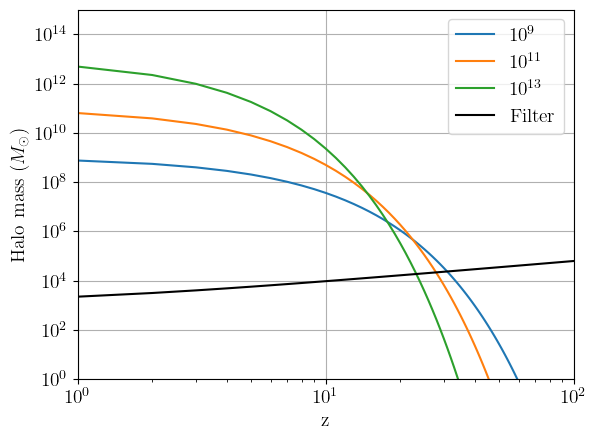

In [66]:
# Plot histories for a few final halo masses: 1e+9, 1e+11.5, 1e+14
z_list=np.arange(0,101)

plt.figure()
plt.plot(z_list, MAH(1e+9,z_list), label=r'$10^{9}$')
plt.plot(z_list, MAH(1e+11,z_list), label=r'$10^{11}$')
plt.plot(z_list, MAH(1e+13,z_list), label=r'$10^{13}$')
plt.plot(z_list, filter_mass(z_list), label='Filter', color='black')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('z')
plt.ylabel(r'Halo mass ($M_\odot$)')
plt.xlim(1,100)
plt.ylim(1,1e+15)
plt.grid()
plt.legend()
plt.show()

As one can see from the graph above, smaller halos that collapse earlier also cross the filtering threshold before higher mass halos. 

Now we define virialization redshift i.e. $M_\textnormal{Halo} (M_0, z_\textnormal{vir}) = M_F (z_\textnormal{vir})$

In [79]:
def zvir(M0):
    return fsolve(lambda z: MAH(M0, z) - filter_mass(z), 30)


In [100]:
MAH(1e+8,31)

np.float64(23772.524134363473)

In [ ]:
23772/(1e+6)

In [94]:
zvir(1e+12)

array([25.76748607])

#### Density evolution

In [98]:
def nH_Halo(zvir, z):

    # Convert arguments to array
    zvir = np.asarray(zvir)
    z = np.asarray(z)
    
    # Define A
    A = (1+zvir)/(1+z)
    # Define conditions for pre and post collapse
    conditions = [
        (z>zvir),
        (z<=zvir)
    ]

    # Define values to return
    funcs=[
        phys.nH0*(1+z)**3 * np.exp((1.9*A) / (1 - 0.75*A**2)),
        1.2 * MAH(1e+8,zvir)/(1e+6) * ((1+zvir) / 10)**(3/2)
        ##phys.nH0*(1+zvir)**3 * np.exp(1.9 / (1 - 0.75))
    ]

    return np.select(conditions, funcs, default=0)

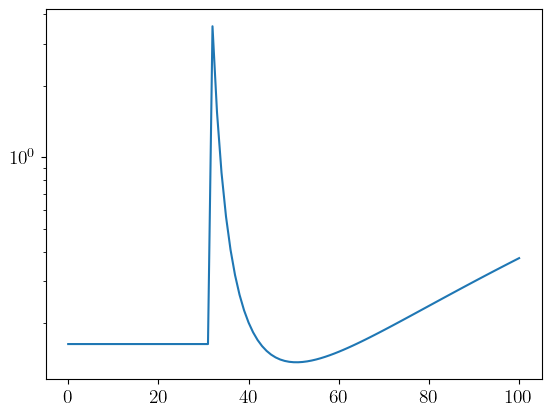

In [99]:
# Now plot halo number density for varying z_virs/ M0
z_list=np.arange(0,101)
zvir_list=np.array([zvir(1e+8), zvir(1e+10), zvir(1e+12)])

plt.figure()
plt.plot(z_list, nH_Halo(zvir_list[0], z_list))

plt.yscale('log')
plt.show()

In [88]:
zvir_list

array([[31.00362177],
       [29.8160556 ],
       [25.76748607]])

In [97]:
MAH(1e+8, 31)

np.float64(23772.524134363473)

#### Temperature evolution

In this part for now, I am only including the adiabatic heating term that arises from gas contraction and relaxation as it falls into the halo and heats up.

This term is given as
$$
    \frac{d T_m}{d z} = \frac{2}{3} \frac{1}{n_H} \frac{d n_H}{d z} T_m
$$

In [ ]:
# Define adiabatic term in temperature heating. 

def dTm_dt_adiabat(z, nH):
    return (2/3)